## Notebook for building ML for CE

### Algorithm: Random Forest (Features scaled)
### Splitting: Random

**Created on 6th July; modified on 10th November, 2022**

**No EA features**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna

In [2]:
%%bash
pwd
ls -ltr

/Users/ritesh2/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/coulombic-efficiency/11-09-22/random-split/with-10-features-each
total 3160
-rw-------@ 1 ritesh2  staff    79036 Nov 10 23:21 15-all_CE_ED_pre_feat.csv
-rw-------@ 1 ritesh2  staff     8137 Nov 10 23:21 15-CE_ood_pre_feat.csv
-rw-------@ 1 ritesh2  staff    86017 Nov 10 23:29 15-tot_CE_ED_ood_pre_feat.csv
-rw-------@ 1 ritesh2  staff   279460 Nov 10 23:35 gen_pretrained_feat_pca.ipynb
-rw-r--r--  1 ritesh2  staff    61278 Nov 10 23:36 tot_CE_ED-ood_pre_feat.csv
-rw-r--r--  1 ritesh2  staff    56131 Nov 10 23:36 all_CE_ED_pre_feat.csv
-rw-r--r--  1 ritesh2  staff     5931 Nov 10 23:36 CE_ood_pre_feat.csv
-rw-------@ 1 ritesh2  staff  1026549 Nov 10 23:38 rf_random_scaled_2.ipynb


In [5]:
df = pd.read_csv('all_CE_ED_pre_feat.csv')
# df.drop(labels=['ea_solv_1','ea_solv_2','ea_solv_3'], axis=1, inplace=True)
# df.reset_index(drop=True, inplace=True)
df

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,...,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density,coulombic_efficiency,log(1-CE)
0,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,NaN,13.960964,-36.666103,-22.260607,16.980927,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,0,2.0,0.80000,-1.609438
1,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,O=S=O,13.960780,-36.666084,-22.260595,16.980879,...,0.481968,13.548994,52.09653,0.002881,3,63.9619,1,5.0,0.83600,-1.807889
2,C1CCOC1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,60.811623,0.946545,-4.255921,20.332489,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,1,5.0,0.89400,-2.244316
3,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,245.147780,29.954426,-0.577181,18.008678,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,1,0.9,0.97400,-3.649659
4,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,245.147780,29.954430,-0.577294,18.008636,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,1,0.9,0.97400,-3.649659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,CO[Si](C)(C)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,5.402024,69.067390,-2.202446,-12.765357,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,2,0.5,0.99759,-6.028129
138,O=S1(=O)CCCC1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,488.717040,59.473896,17.828417,-12.404927,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,2,0.5,0.98200,-4.017384
139,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-157.245940,-93.020430,51.873350,-13.462182,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,2,0.5,0.98800,-4.422849
140,COC1OCC(C(F)(F)F)O1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-302.425700,-50.619164,7.512139,-11.243821,...,0.000000,0.000000,0.00000,0.000000,0,0.0000,2,1.0,0.98700,-4.342806


In [ ]:
# df.drop(labels=['protocol'], axis=1, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df

In [4]:
print(df['coulombic_efficiency'].min())
print(df['coulombic_efficiency'].max())

0.09
0.9994


In [6]:
df_train = pd.read_csv('train_CE_pre_feat.csv')
df_val = pd.read_csv('val_CE_pre_feat.csv')
df_test = pd.read_csv('test_CE_pre_feat.csv')
# df_train.drop(labels=['ea_solv_1','ea_solv_2','ea_solv_3'], axis=1, inplace=True)
# df_train.reset_index(drop=True, inplace=True)
# df_val.drop(labels=['ea_solv_1','ea_solv_2','ea_solv_3'], axis=1, inplace=True)
# df_val.reset_index(drop=True, inplace=True)
# df_test.drop(labels=['ea_solv_1','ea_solv_2','ea_solv_3'], axis=1, inplace=True)
# df_test.reset_index(drop=True, inplace=True)
df_train

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,...,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density,coulombic_efficiency,log(1-CE)
0,O=C1OCCO1,COC(=O)OC,COCCOCCOCCOCCOC,F[P-](F)(F)(F)(F)F.[Li+],NaN,O=[N+]([O-])[O-].[Li+],-46.484962,2.137504,-36.859737,-18.511263,...,2.457975,-4.113442,-0.597053,0.002881,5,69.003822,1,2.0,0.980,-3.912023
1,COC(=O)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-531.517600,114.241776,-17.059505,-51.076942,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.5,0.090,-0.094311
2,COCCOCCOCCOCCOC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,O=C1OCCO1,-58.305626,142.530330,15.399387,-11.378302,...,7.568721,1.898202,-4.439598,0.002881,6,88.016044,1,0.4,0.973,-3.611918
3,O=C1OCCO1,COC(=O)OC,NaN,F[P-](F)(F)(F)(F)F.[Li+],NaN,NaN,5.023019,-14.752433,-41.280296,-18.337510,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.6,0.957,-3.146555
4,COCCOC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F.[Li+],NaN,-529.239440,99.002686,10.163011,36.577763,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.5,0.917,-2.488915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,O=C1OCCO1,CCOC(=O)OCC,NaN,F[P-](F)(F)(F)(F)F.[Li+],NaN,O=C1OCC(F)O1,264.508150,-11.799558,-34.609314,-8.300950,...,-4.349967,0.737187,2.353765,0.002881,7,106.006622,3,0.5,0.950,-2.995732
109,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,O=S=O,13.960780,-36.666084,-22.260595,16.980879,...,0.481968,13.548994,52.096530,0.002881,3,63.961900,1,5.0,0.836,-1.807889
110,CCOCCOCC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,422.106300,105.700580,14.954724,14.717519,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,-1,0.5,0.990,-4.605170
111,COC(=O)CC(F)(F)F,O=C1OCC(F)O1,NaN,F[P-](F)(F)(F)(F)F.[Li+],NaN,NaN,-338.781980,-116.616060,8.934224,1.737642,...,0.000000,0.000000,0.000000,0.000000,0,0.000000,2,0.5,0.976,-3.729701


In [6]:
# df_train.drop(labels=['protocol'], axis=1, inplace=True)
# df_train.reset_index(drop=True, inplace=True)
# df_val.drop(labels=['protocol'], axis=1, inplace=True)
# df_val.reset_index(drop=True, inplace=True)
# df_test.drop(labels=['protocol'], axis=1, inplace=True)
# df_test.reset_index(drop=True, inplace=True)

In [7]:
X_train = df_train.iloc[:,6:-2]
y_train = df_train.iloc[:,-1]
X_train

,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,pre_feat_solv_5,pre_feat_solv_6,pre_feat_solv_7,pre_feat_solv_8,pre_feat_solv_9,pre_feat_solv_10,...,pre_feat_add_5,pre_feat_add_6,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density
0,-46.484962,2.137504,-36.859737,-18.511263,-11.967629,-4.719866,0.412746,5.565085,3.641733,1.146037,...,-10.243922,3.219527,2.457975,-4.113442,-0.597053,0.002881,5,69.003822,1,2.0
1,-531.517600,114.241776,-17.059505,-51.076942,25.449867,32.122830,-3.383841,-4.839263,12.029801,-2.920044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.5
2,-58.305626,142.530330,15.399387,-11.378302,10.246004,-18.375586,8.442172,-19.556969,12.388557,-18.397964,...,-9.969856,19.285337,7.568721,1.898202,-4.439598,0.002881,6,88.016044,1,0.4
3,5.023019,-14.752433,-41.280296,-18.337510,-6.635223,-9.778509,5.046108,12.535081,10.950474,-0.299167,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.6
4,-529.239440,99.002686,10.163011,36.577763,-28.838840,5.242561,-9.384583,13.633237,-4.331480,1.174064,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,264.508150,-11.799558,-34.609314,-8.300950,-9.178205,-5.388664,-1.338223,6.058027,-1.705974,-2.999915,...,-12.178342,-14.428220,-4.349967,0.737187,2.353765,0.002881,7,106.006622,3,0.5
109,13.960780,-36.666084,-22.260595,16.980879,8.733830,24.343128,-13.190999,-21.466469,-0.957701,-12.557279,...,21.922450,23.375114,0.481968,13.548994,52.096530,0.002881,3,63.961900,1,5.0
110,422.106300,105.700580,14.954724,14.717519,-17.380800,-10.149747,-1.003756,-28.657234,9.132141,-19.345495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,-1,0.5
111,-338.781980,-116.616060,8.934224,1.737642,-5.764315,16.616102,4.778477,-15.004423,1.596953,4.524093,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,2,0.5


In [8]:
X_val = df_val.iloc[:,6:-2]
y_val = df_val.iloc[:,-1]
X_test = df_test.iloc[:,6:-2]
y_test = df_test.iloc[:,-1]

In [9]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)
X_val_std

,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,pre_feat_solv_5,pre_feat_solv_6,pre_feat_solv_7,pre_feat_solv_8,pre_feat_solv_9,pre_feat_solv_10,...,pre_feat_add_5,pre_feat_add_6,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density
0,0.731983,-0.241047,-1.085841,-0.388315,-0.402043,-0.387514,0.043324,0.537218,-0.188877,-0.232769,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,-0.235151,-0.782734
1,0.009288,0.989620,0.008569,-0.602731,1.600404,0.639884,1.522946,0.581448,-0.616561,1.118186,...,-1.500081,0.361817,0.400014,-0.872702,-0.172795,2.093063,1.374278,1.147955,-0.235151,1.004114
2,0.731983,-0.241047,-1.085841,-0.388315,-0.402043,-0.387514,0.043324,0.537218,-0.188877,-0.232769,...,-1.792167,-2.013207,-0.791590,0.138201,0.403058,2.093046,2.093229,1.987046,1.536322,-0.782734
3,-0.383085,1.500984,0.311739,-0.185353,-0.238395,-0.939328,1.122433,-1.317330,0.631931,-0.106039,...,-1.458699,2.523945,1.294556,0.380164,-0.922669,2.093069,1.733753,1.579084,-0.235151,-0.500600
4,0.710709,-0.383782,1.912246,-0.722195,-0.505271,-1.262617,-2.454824,-0.556420,0.990408,1.810911,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,1.536322,-0.688690
5,-1.358213,-0.911232,0.524147,-1.012026,0.533671,-0.057191,0.524427,0.734388,-1.125726,0.677532,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
6,0.008231,-0.285985,-1.311126,-0.870350,-0.276942,-0.664729,0.528080,1.060745,0.940135,0.022587,...,2.690756,-3.543054,-0.654271,-0.064563,-0.201435,2.093072,1.733753,1.533376,-0.235151,-0.312511
7,0.731983,-0.241047,-1.085841,-0.388315,-0.402043,-0.387514,0.043324,0.537218,-0.188877,-0.232769,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,-0.235151,0.063667
8,0.360606,-0.153750,2.116398,-1.546098,0.335552,-0.147331,0.326446,1.153713,0.096349,-0.660281,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,1.536322,-0.782734
9,0.124532,-0.453801,-1.268553,-0.687900,-0.367027,-0.527095,0.511587,1.032473,1.051968,-0.072089,...,0.046688,-0.071465,-0.030209,-0.015433,-0.056280,-0.477767,-0.423099,-0.416804,-1.120888,1.474337


#### BHO by minimizing on train

In [10]:
def rmse_score(score):
    rmse = np.sqrt(-score)
    return rmse

In [11]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 300),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    # rf.fit(X_train, y_train)
    # y_pred_train = rf.predict(X_train)
    # score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    score = cross_val_score(rf, X_train_std, y_train, cv=kf, scoring="neg_mean_squared_error")
    return rmse_score(score.mean())

In [12]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-10 23:44:15,617] A new study created in memory with name: no-name-7272f053-a7ae-41e0-878b-98dd57ea0b11
[I 2022-11-10 23:44:17,525] Trial 0 finished with value: 1.176869601290856 and parameters: {'min_samples_split': 18, 'min_samples_leaf': 3, 'n_estimators': 213, 'max_features': 'sqrt', 'max_depth': 5, 'max_leaf_nodes': 26, 'random_state': 39}. Best is trial 0 with value: 1.176869601290856.
[I 2022-11-10 23:44:18,824] Trial 1 finished with value: 1.159714719987148 and parameters: {'min_samples_split': 11, 'min_samples_leaf': 7, 'n_estimators': 170, 'max_features': 'auto', 'max_depth': 27, 'max_leaf_nodes': 17, 'random_state': 24}. Best is trial 1 with value: 1.159714719987148.
[I 2022-11-10 23:44:20,348] Trial 2 finished with value: 1.173435759773773 and parameters: {'min_samples_split': 11, 'min_samples_leaf': 5, 'n_estimators': 266, 'max_features': 'log2', 'max_depth': 44, 'max_leaf_nodes': 18, 'random_state': 56}. Best is trial 1 with value: 1.159714719987148.
[I 2022-11-

Number of finished trials: 200
Best trial:
  Value: 1.089642927305416
  Params: 
    min_samples_split: 10
    min_samples_leaf: 2
    n_estimators: 35
    max_features: auto
    max_depth: 10
    max_leaf_nodes: 16
    random_state: 75


Run the ML using best hyperparameters

In [13]:
def read_param(param):
    file_name = 'best-paramters_rf_' + str(param) + '.txt'
    # file_name = 'best-paramters_rf_optuna_' + str(sys.argv[1]) + '.txt'
    f0 = open(file_name,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = int(b[1][1]); p2 = int(b[2][1]); p3 = int(b[3][1]); p4 = str(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = int(b[7][1])
    #p9 = int(b[9][1])
    return p1, p2, p3, p4, p5, p6, p7

In [14]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)
# rf = RandomForestRegressor(**params)
# rf.fit(X_train, y_train)
# y_pred_train = rf.predict(X_train) 
# y_pred_val = rf.predict(X_val) 

10 2 35 auto 10 16 75


In [15]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
0.74238178350261 0.9465089256148932
counter for cv split:  1
0.8605055231337346 1.0493897468670317
counter for cv split:  2
0.7507312308947857 1.107152646750139
counter for cv split:  3
0.698753615561488 1.0368963009946899
counter for cv split:  4
0.7431123328460401 0.8568538648389236
counter for cv split:  5
0.7088837453917497 1.048919104214011
counter for cv split:  6
0.7156836240782848 0.8991895994169349
counter for cv split:  7
0.7693591860757008 0.8645959316216811
counter for cv split:  8
0.7415192680080183 1.0338620180691915
counter for cv split:  9
0.7801161405191261 0.9581177258607311
counter for cv split:  10
0.7964906742434 1.0635336384813927
counter for cv split:  11
0.7441210279959211 0.9566786961833003
counter for cv split:  12
0.7449627757756857 1.0351446306018406
counter for cv split:  13
0.7305754172893922 1.0146428466256525
counter for cv split:  14
0.7326396826394141 1.045908994429296
counter for cv split:  15
0.7350121081663772 1.032640914004

In [16]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

4
Best RMSE for train/val: 0.7431123328460401/0.8568538648389236
Best R2 for train/val: 0.6924964525610122/0.43462875854087313


In [17]:
model_1 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.7431123328460401 / 0.8568538648389236 / 1.0724103414229562
R2 for train / validation / test: 0.6924964525610122 / 0.43462875854087313 / 0.4020896730865243


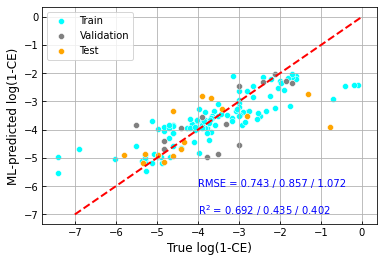

In [18]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

**Deploy on OOD**

In [19]:
df_ood = pd.read_csv('CE_ood_pre_feat.csv')
# df_ood.drop(labels=['ea_solv_1','ea_solv_2','ea_solv_3'], axis=1, inplace=True)
# df_ood.reset_index(drop=True, inplace=True)
df_ood

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,...,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density,coulombic_efficiency,log(1-CE)
0,FC(F)(F)COCCOCCOCC(F)(F)F,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,568.741330,57.725716,52.314514,-26.843203,...,0,0,0,0,0,0,2,0.5,0.991411,-4.757323
1,FCCOCCOCCOCCF,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,314.174320,136.484940,26.495731,-17.763567,...,0,0,0,0,0,0,2,0.5,0.874748,-2.077424
2,FCCOB(OCCF)OCCF,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,696.377750,107.865710,38.945183,-24.380642,...,0,0,0,0,0,0,2,0.5,0.974297,-3.661161
3,CCOC(OCC)OCC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-495.069200,19.423439,-9.941760,11.514219,...,0,0,0,0,0,0,2,0.5,0.984961,-4.197091
4,COCCOCC(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,155.699400,-110.856630,5.280405,77.235680,...,0,0,0,0,0,0,2,0.5,0.974294,-3.661018
5,COCCOB(OCCOC)OCCOC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,67.646700,155.913680,11.699912,-25.080843,...,0,0,0,0,0,0,2,0.5,0.550291,-0.799155
6,FCCOB(OCCF)OCCF,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,696.377750,107.865710,38.945183,-24.380642,...,0,0,0,0,0,0,2,0.1,0.966902,-3.408275
7,COCCOC(C)(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,307.999420,-51.896534,12.827153,70.621666,...,0,0,0,0,0,0,2,0.5,0.982281,-4.033095
8,CCCCOCCOC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,0.473899,113.481330,17.095774,19.033155,...,0,0,0,0,0,0,2,0.5,0.983000,-4.074542
9,COCCOC(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,254.200800,-89.463520,6.972825,83.248620,...,0,0,0,0,0,0,2,0.5,0.985000,-4.199705


In [20]:
X_ood = df_ood.iloc[:,6:-2]
y_ood = df_ood.iloc[:,-1]
X_ood

,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,pre_feat_solv_5,pre_feat_solv_6,pre_feat_solv_7,pre_feat_solv_8,pre_feat_solv_9,pre_feat_solv_10,...,pre_feat_add_5,pre_feat_add_6,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density
0,568.741330,57.725716,52.314514,-26.843203,13.405765,8.493670,3.161298,25.868860,-8.571390,-16.418213,...,0,0,0,0,0,0,0,0,2,0.5
1,314.174320,136.484940,26.495731,-17.763567,15.258575,6.446876,6.723159,-17.591743,4.628298,-17.381075,...,0,0,0,0,0,0,0,0,2,0.5
2,696.377750,107.865710,38.945183,-24.380642,-12.844133,-15.364827,-1.055941,-16.993942,-21.821970,10.203899,...,0,0,0,0,0,0,0,0,2,0.5
3,-495.069200,19.423439,-9.941760,11.514219,8.910452,-9.091766,26.418667,6.267409,-18.140549,16.178228,...,0,0,0,0,0,0,0,0,2,0.5
4,155.699400,-110.856630,5.280405,77.235680,9.402537,8.391991,25.351292,9.018285,14.835892,-20.774914,...,0,0,0,0,0,0,0,0,2,0.5
5,67.646700,155.913680,11.699912,-25.080843,-0.243393,-24.124810,-8.694117,13.481190,-5.478823,33.760820,...,0,0,0,0,0,0,0,0,2,0.5
6,696.377750,107.865710,38.945183,-24.380642,-12.844133,-15.364827,-1.055941,-16.993942,-21.821970,10.203899,...,0,0,0,0,0,0,0,0,2,0.1
7,307.999420,-51.896534,12.827153,70.621666,17.702200,16.891184,26.094503,13.102829,14.195604,-10.032532,...,0,0,0,0,0,0,0,0,2,0.5
8,0.473899,113.481330,17.095774,19.033155,-10.999088,-10.033943,5.146527,-14.117541,1.496447,-4.443938,...,0,0,0,0,0,0,0,0,2,0.5
9,254.200800,-89.463520,6.972825,83.248620,9.417172,14.582830,22.372253,14.008273,10.369975,-12.614752,...,0,0,0,0,0,0,0,0,2,0.5


In [21]:
X_ood_std = std_scale.transform(X_ood)
X_ood_std = pd.DataFrame(X_ood_std, columns=X_train.columns)
X_ood_std

,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,pre_feat_solv_5,pre_feat_solv_6,pre_feat_solv_7,pre_feat_solv_8,pre_feat_solv_9,pre_feat_solv_10,...,pre_feat_add_5,pre_feat_add_6,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density
0,1.580545,0.817018,1.849657,-1.278861,0.708971,0.489143,0.384968,2.138487,-0.801303,-1.501468,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
1,0.870511,2.015609,0.977733,-0.842785,0.800119,0.359890,0.655416,-1.374343,0.376169,-1.592507,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
2,1.936547,1.580070,1.398162,-1.160589,-0.582388,-1.017500,0.064758,-1.326024,-1.983315,1.015652,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
3,-1.386619,0.234118,-0.252795,0.563367,0.487825,-0.621362,2.150874,0.554142,-1.654915,1.580524,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
4,0.428495,-1.748540,0.261272,3.719834,0.512033,0.482722,2.069830,0.776490,1.286732,-1.913394,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
5,0.182900,2.311284,0.478064,-1.194219,0.037503,-1.570686,-0.515201,1.137217,-0.525432,3.242958,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
6,1.936547,1.580070,1.398162,-1.160589,-0.582388,-1.017500,0.064758,-1.326024,-1.983315,1.015652,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.782734
7,0.853288,-0.851260,0.516132,3.402176,0.920333,1.019439,2.126261,1.106635,1.229615,-0.897702,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
8,-0.004458,1.665531,0.660287,0.924486,-0.491621,-0.680860,0.535704,-1.093531,0.096793,-0.369301,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
9,0.703233,-1.422970,0.318426,4.008623,0.512753,0.873668,1.843635,1.179820,0.888352,-1.141851,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556


In [22]:
y_pred_ood = model_1.predict(X_ood_std)
y_pred_ood

array([-4.7795401 , -4.14911334, -4.68745557, -4.31312721, -4.55110534,
       -3.74553453, -4.68745557, -4.42876747, -4.02525135, -4.56622661,
       -4.55110534, -4.53160642, -3.82157697, -4.78699137])

In [23]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR$^2$ = {r2:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True log(1-CE)')
    plt.ylabel('ML-predicted log(1-CE)')
    
    plt.show()
    
    return

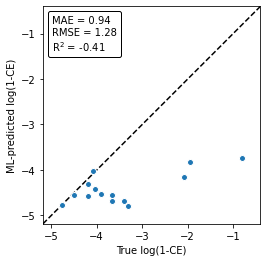

In [24]:
plot_parity(y_ood, y_pred_ood)

#### BHO - 2nd trial

In [25]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 20, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 500),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    # rf.fit(X_train, y_train)
    # y_pred_train = rf.predict(X_train)
    # score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    score = cross_val_score(rf, X_train_std, y_train, cv=kf, scoring="neg_mean_squared_error")
    return rmse_score(score.mean())

In [26]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-10 23:47:28,253] A new study created in memory with name: no-name-efb11c56-21cb-4159-aec4-6c557fbf4e7b
[I 2022-11-10 23:47:31,439] Trial 0 finished with value: 1.2214882461073397 and parameters: {'min_samples_split': 23, 'min_samples_leaf': 8, 'n_estimators': 484, 'max_features': 'log2', 'max_depth': 19, 'max_leaf_nodes': 5, 'random_state': 37}. Best is trial 0 with value: 1.2214882461073397.
[I 2022-11-10 23:47:35,124] Trial 1 finished with value: 1.1833786346166932 and parameters: {'min_samples_split': 40, 'min_samples_leaf': 8, 'n_estimators': 498, 'max_features': 'auto', 'max_depth': 17, 'max_leaf_nodes': 35, 'random_state': 49}. Best is trial 1 with value: 1.1833786346166932.
[I 2022-11-10 23:47:35,965] Trial 2 finished with value: 1.2319020199742752 and parameters: {'min_samples_split': 40, 'min_samples_leaf': 6, 'n_estimators': 144, 'max_features': 'log2', 'max_depth': 21, 'max_leaf_nodes': 39, 'random_state': 58}. Best is trial 1 with value: 1.1833786346166932.
[I 20

Number of finished trials: 200
Best trial:
  Value: 1.1441609851107715
  Params: 
    min_samples_split: 23
    min_samples_leaf: 5
    n_estimators: 20
    max_features: auto
    max_depth: 30
    max_leaf_nodes: 13
    random_state: 24


In [27]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

23 5 20 auto 30 13 24


In [28]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
0.9779289891606814 0.9979792073533051
counter for cv split:  1
1.0064254526775647 1.0481680667207107
counter for cv split:  2
0.9600988109400423 1.1170480861627743
counter for cv split:  3
0.9362809535703046 1.042014883300301
counter for cv split:  4
0.9858095771162071 1.0019315272318274
counter for cv split:  5
0.937821172032843 0.9832499691052871
counter for cv split:  6
0.9585286977281103 1.0614849600876095
counter for cv split:  7
0.9545081158641433 1.0569092873462116
counter for cv split:  8
0.9283251834462474 1.063467750126797
counter for cv split:  9
0.9502653886135459 1.0686953110635393
counter for cv split:  10
0.989734489052872 1.0410164531583925
counter for cv split:  11
0.9598342141679902 0.9971673730673554
counter for cv split:  12
0.9631017111338278 1.1116974686540249
counter for cv split:  13
0.9342919011044077 1.0509305626326177
counter for cv split:  14
0.9693709486454426 1.0461859968575244
counter for cv split:  15
0.9753274756997047 1.0306911

In [29]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

89
Best RMSE for train/val: 0.9395818251098524/0.8969910752809537
Best R2 for train/val: 0.5084016608122555/0.3804213590362242


In [30]:
model_2 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.9395818251098524 / 0.8969910752809537 / 1.0709344329603918
R2 for train / validation / test: 0.5084016608122555 / 0.3804213590362242 / 0.4037342929346074


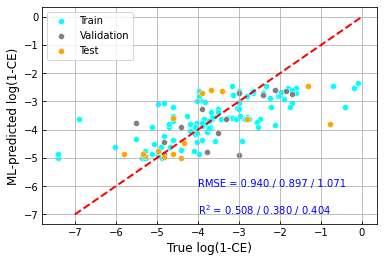

In [31]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

**Predict on OOD**

In [32]:
y_pred_ood = model_2.predict(X_ood_std)
y_pred_ood

array([-4.97653478, -4.29639627, -4.76495113, -3.78903011, -4.12978863,
       -4.53108225, -4.76495113, -4.12978863, -4.38193374, -4.23370294,
       -4.12978863, -4.31387013, -3.56500619, -4.48025931])

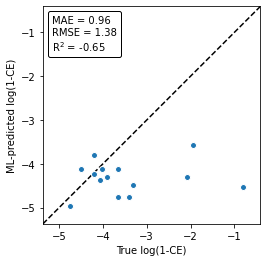

In [33]:
plot_parity(y_ood, y_pred_ood)

#### BHO - 3rd trial

In [34]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 20, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 500),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    # rf.fit(X_train, y_train)
    # y_pred_train = rf.predict(X_train)
    # score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    score = cross_val_score(rf, X_train_std, y_train, cv=kf, scoring="neg_mean_squared_error")
    return rmse_score(score.mean())

In [35]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-10 23:51:13,882] A new study created in memory with name: no-name-6d05d049-9c7a-4516-9fcf-98db502ae5dd
[I 2022-11-10 23:51:17,288] Trial 0 finished with value: 1.1736914281407071 and parameters: {'min_samples_split': 35, 'min_samples_leaf': 5, 'n_estimators': 473, 'max_features': 'auto', 'max_depth': 4, 'max_leaf_nodes': 19, 'random_state': 30}. Best is trial 0 with value: 1.1736914281407071.
[I 2022-11-10 23:51:19,816] Trial 1 finished with value: 1.1793247773897688 and parameters: {'min_samples_split': 36, 'min_samples_leaf': 8, 'n_estimators': 364, 'max_features': 'auto', 'max_depth': 22, 'max_leaf_nodes': 32, 'random_state': 30}. Best is trial 0 with value: 1.1736914281407071.
[I 2022-11-10 23:51:21,403] Trial 2 finished with value: 1.250835148634079 and parameters: {'min_samples_split': 41, 'min_samples_leaf': 7, 'n_estimators': 292, 'max_features': 'log2', 'max_depth': 7, 'max_leaf_nodes': 24, 'random_state': 45}. Best is trial 0 with value: 1.1736914281407071.
[I 2022

Number of finished trials: 200
Best trial:
  Value: 1.141781005823787
  Params: 
    min_samples_split: 20
    min_samples_leaf: 3
    n_estimators: 329
    max_features: auto
    max_depth: 13
    max_leaf_nodes: 16
    random_state: 11


In [36]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

20 3 329 auto 13 16 11


In [37]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
0.8780516389451641 0.9358364736824752
counter for cv split:  1
0.9591306804783297 1.056201257387389
counter for cv split:  2
0.8977077971062767 1.0783472059620145
counter for cv split:  3
0.8572635498729089 1.0246894997512157
counter for cv split:  4
0.908464258712857 1.01997465465088
counter for cv split:  5
0.8701339112383241 0.9905346455426454
counter for cv split:  6
0.8729279226945771 0.9838300445537572
counter for cv split:  7
0.9084337188923347 0.9561870070712734
counter for cv split:  8
0.8778345208598476 1.0096826970369468
counter for cv split:  9
0.8686364554362235 1.0629791213540987
counter for cv split:  10
0.9117452236990752 1.0450893207872223
counter for cv split:  11
0.8856693467482204 1.0125670511292286
counter for cv split:  12
0.8779565289088124 1.1278082043271165
counter for cv split:  13
0.8507013615784739 1.023307305832318
counter for cv split:  14
0.8661497291764962 1.0641118184379277
counter for cv split:  15
0.8680706113213278 1.02519522

In [38]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

61
Best RMSE for train/val: 0.8698415927201657/0.8650608202743714
Best R2 for train/val: 0.578670825211639/0.42374662881724856


In [39]:
model_3 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.8698415927201657 / 0.8650608202743714 / 1.1326400405364183
R2 for train / validation / test: 0.578670825211639 / 0.42374662881724856 / 0.3330429172056901


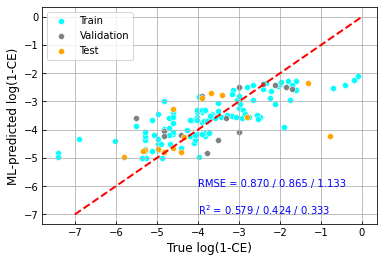

In [40]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

**Predict on OOD**

In [41]:
y_pred_ood = model_3.predict(X_ood_std)
y_pred_ood

array([-4.28374763, -3.80799754, -4.28463056, -3.73278984, -4.17389812,
       -3.77748237, -4.23823014, -4.14667326, -3.59074194, -4.18879388,
       -4.15735653, -3.98988736, -3.42489419, -4.09978493])

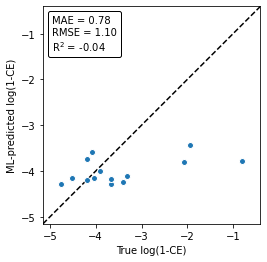

In [42]:
plot_parity(y_ood, y_pred_ood)

#### BHO by minimizing on validation

In [43]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 300),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = rf.predict(X_val_std)
    score = -mean_squared_error(y_val, preds)
    return rmse_score(score.mean())

In [44]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-11 00:00:28,340] A new study created in memory with name: no-name-9427bb1b-cb85-4fbd-928a-1b00b9b8ef57
[I 2022-11-11 00:00:29,588] Trial 0 finished with value: 0.9741180920909559 and parameters: {'min_samples_split': 22, 'min_samples_leaf': 7, 'n_estimators': 221, 'max_features': 'auto', 'max_depth': 44, 'max_leaf_nodes': 21, 'random_state': 98}. Best is trial 0 with value: 0.9741180920909559.
[I 2022-11-11 00:00:30,674] Trial 1 finished with value: 0.9721061633662217 and parameters: {'min_samples_split': 13, 'min_samples_leaf': 1, 'n_estimators': 125, 'max_features': 'auto', 'max_depth': 33, 'max_leaf_nodes': 19, 'random_state': 58}. Best is trial 1 with value: 0.9721061633662217.
[I 2022-11-11 00:00:32,760] Trial 2 finished with value: 0.9718483470421508 and parameters: {'min_samples_split': 23, 'min_samples_leaf': 4, 'n_estimators': 251, 'max_features': 'auto', 'max_depth': 13, 'max_leaf_nodes': 35, 'random_state': 68}. Best is trial 2 with value: 0.9718483470421508.
[I 2

Number of finished trials: 200
Best trial:
  Value: 0.8441216981472839
  Params: 
    min_samples_split: 21
    min_samples_leaf: 9
    n_estimators: 21
    max_features: auto
    max_depth: 24
    max_leaf_nodes: 38
    random_state: 35


In [45]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

21 9 21 auto 24 38 35


In [46]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
0.996582868738698 0.8441216981472839
counter for cv split:  1
1.0319516289183408 1.0491888093141997
counter for cv split:  2
0.9937582784370776 1.1007473226100222
counter for cv split:  3
1.0037502757587202 1.0324109828097605
counter for cv split:  4
1.0006067108533727 1.0572785097856423
counter for cv split:  5
0.9875901246608 0.974527588817191
counter for cv split:  6
0.9854614176678774 1.0578490049203764
counter for cv split:  7
0.9895019101599264 0.9839299944744505
counter for cv split:  8
0.9951034627736794 0.9908079270556318
counter for cv split:  9
0.9991952569533525 0.9853480936936241
counter for cv split:  10
1.0293734830417853 1.0882763710502983
counter for cv split:  11
1.0144631778439206 1.0012792834535549
counter for cv split:  12
1.0224336472035267 1.0963520182233362
counter for cv split:  13
0.9671215396219319 1.064819367202469
counter for cv split:  14
0.9730542336841631 1.089456214013694
counter for cv split:  15
0.9805939661904132 1.0095093215

In [46]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=38, max_leaf_nodes=13, min_samples_leaf=10,
                      min_samples_split=28, n_estimators=26, random_state=74)>

In [47]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

0
Best RMSE for train/val: 0.996582868738698/0.8441216981472839
Best R2 for train/val: 0.44694537693114167/0.4513058604998923


In [48]:
model_4 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.996582868738698 / 0.8441216981472839 / 1.1376055845599569
R2 for train / validation / test: 0.44694537693114167 / 0.4513058604998923 / 0.32718215970659126


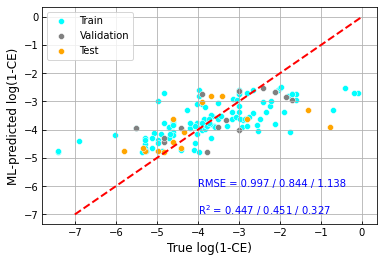

In [49]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

In [50]:
y_pred_ood = model_4.predict(X_ood_std)
y_pred_ood

array([-4.48021407, -4.06949681, -4.53536301, -3.79912487, -3.73497533,
       -4.09608972, -4.53536301, -3.74692713, -3.92469682, -3.79761334,
       -3.73497533, -3.87963596, -3.54686596, -3.96839796])

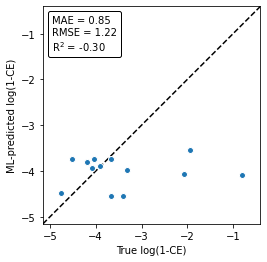

In [51]:
plot_parity(y_ood, y_pred_ood)

#### BHO - 5th trial

In [52]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 300),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = rf.predict(X_val_std)
    score = -mean_squared_error(y_val, preds)
    return rmse_score(score.mean())

In [53]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-11 00:02:02,086] A new study created in memory with name: no-name-dac81198-80fc-4717-84d8-e545c8a13788
[I 2022-11-11 00:02:03,045] Trial 0 finished with value: 1.0462273794079113 and parameters: {'min_samples_split': 9, 'min_samples_leaf': 10, 'n_estimators': 191, 'max_features': 'sqrt', 'max_depth': 48, 'max_leaf_nodes': 10, 'random_state': 33}. Best is trial 0 with value: 1.0462273794079113.
[I 2022-11-11 00:02:03,338] Trial 1 finished with value: 1.0341202148719824 and parameters: {'min_samples_split': 27, 'min_samples_leaf': 10, 'n_estimators': 40, 'max_features': 'log2', 'max_depth': 33, 'max_leaf_nodes': 20, 'random_state': 32}. Best is trial 1 with value: 1.0341202148719824.
[I 2022-11-11 00:02:04,242] Trial 2 finished with value: 1.0766943645397111 and parameters: {'min_samples_split': 16, 'min_samples_leaf': 8, 'n_estimators': 92, 'max_features': 'log2', 'max_depth': 39, 'max_leaf_nodes': 10, 'random_state': 64}. Best is trial 1 with value: 1.0341202148719824.
[I 20

Number of finished trials: 200
Best trial:
  Value: 0.8601113360434479
  Params: 
    min_samples_split: 15
    min_samples_leaf: 4
    n_estimators: 25
    max_features: auto
    max_depth: 24
    max_leaf_nodes: 40
    random_state: 69


In [54]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

15 4 25 auto 24 40 69


In [55]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
0.8985712741162845 0.8601113360434479
counter for cv split:  1
0.9475360176079246 1.003952635050638
counter for cv split:  2
0.8659994322754845 1.005221395327826
counter for cv split:  3
0.8471974652264761 1.0213880316412536
counter for cv split:  4
0.9094894636035054 1.0002821298892295
counter for cv split:  5
0.8537741520136725 0.9955733767151378
counter for cv split:  6
0.8690011451367411 1.0141253113839714
counter for cv split:  7
0.8645639462349181 0.9935301812586614
counter for cv split:  8
0.8653895364001345 1.0486834977200572
counter for cv split:  9
0.8871321877365554 0.9940541489474796
counter for cv split:  10
0.919403216099639 1.0999140890198227
counter for cv split:  11
0.8585151814068852 1.0914151312204035
counter for cv split:  12
0.871155734789305 1.110537355935147
counter for cv split:  13
0.8525253870478684 1.0835204636427382
counter for cv split:  14
0.8549648443809689 0.9913255439493336
counter for cv split:  15
0.8441419625418359 0.98635723

In [56]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

61
Best RMSE for train/val: 0.8585863432342145/0.8516077418310627
Best R2 for train/val: 0.5895037965822636/0.441530582641842


In [57]:
model_5 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.8585863432342145 / 0.8516077418310627 / 1.1595254389201048
R2 for train / validation / test: 0.5895037965822636 / 0.441530582641842 / 0.3010040972639503


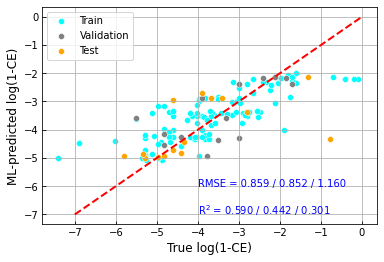

In [58]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

In [59]:
y_pred_ood = model_5.predict(X_ood_std)
y_pred_ood

array([-4.45252103, -3.71797824, -4.42689542, -3.33928853, -4.41581038,
       -3.95698919, -4.42689542, -4.19440738, -3.84022052, -4.28618708,
       -4.38627521, -3.69060733, -3.0114991 , -4.11277186])

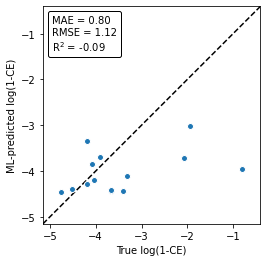

In [60]:
plot_parity(y_ood, y_pred_ood)

#### BHO - 6th trial

In [61]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 300),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = rf.predict(X_val_std)
    score = -mean_squared_error(y_val, preds)
    return rmse_score(score.mean())

In [62]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

[I 2022-11-11 00:04:02,382] A new study created in memory with name: no-name-6dd82757-f72b-48c8-9f1e-f510a06d7073
[I 2022-11-11 00:04:03,603] Trial 0 finished with value: 1.0416480649481872 and parameters: {'min_samples_split': 5, 'min_samples_leaf': 8, 'n_estimators': 217, 'max_features': 'log2', 'max_depth': 11, 'max_leaf_nodes': 49, 'random_state': 54}. Best is trial 0 with value: 1.0416480649481872.
[I 2022-11-11 00:04:04,018] Trial 1 finished with value: 0.9378652735741743 and parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'n_estimators': 72, 'max_features': 'auto', 'max_depth': 10, 'max_leaf_nodes': 47, 'random_state': 51}. Best is trial 1 with value: 0.9378652735741743.
[I 2022-11-11 00:04:04,917] Trial 2 finished with value: 1.0356938491675032 and parameters: {'min_samples_split': 5, 'min_samples_leaf': 7, 'n_estimators': 186, 'max_features': 'log2', 'max_depth': 50, 'max_leaf_nodes': 27, 'random_state': 61}. Best is trial 1 with value: 0.9378652735741743.
[I 202

Number of finished trials: 200
Best trial:
  Value: 0.9043692147767585
  Params: 
    min_samples_split: 7
    min_samples_leaf: 10
    n_estimators: 20
    max_features: auto
    max_depth: 18
    max_leaf_nodes: 33
    random_state: 18


In [63]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

7 10 20 auto 18 33 18


In [64]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_val = rf.predict(X_val_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(rf)

counter for cv split:  0
1.0208633121917299 0.9043692147767585
counter for cv split:  1
1.0250818739885939 1.0843107849896225
counter for cv split:  2
0.9965316215031864 1.0389832795531002
counter for cv split:  3
0.9824663452419327 1.006196480075597
counter for cv split:  4
1.0104808745322071 1.0130669536959276
counter for cv split:  5
0.9823185063932846 0.910660198085541
counter for cv split:  6
1.0179084039827955 1.1370173930533551
counter for cv split:  7
0.9973318540126432 0.9266197544913359
counter for cv split:  8
1.0103031048521776 0.9517018851105373
counter for cv split:  9
0.9768909111210433 1.0091338269430772
counter for cv split:  10
1.0209034387162714 1.043240656244008
counter for cv split:  11
1.0024190433819367 1.0492181314876001
counter for cv split:  12
0.9962739623748534 1.048036812622608
counter for cv split:  13
0.972559261467164 0.9611446172216526
counter for cv split:  14
0.9796617003443191 1.0664456035630985
counter for cv split:  15
0.9875621717344818 0.96600291

In [65]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

51
Best RMSE for train/val: 1.0339258397425557/0.8354988323730741
Best R2 for train/val: 0.40472181023399234/0.4624586368697693


In [66]:
model_6 = model[ind]
y_pred_train = model[ind].predict(X_train_std)
y_pred_val = model[ind].predict(X_val_std)
y_pred_test = model[ind].predict(X_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 1.0339258397425557 / 0.8354988323730741 / 1.1588879755628916
R2 for train / validation / test: 0.40472181023399234 / 0.4624586368697693 / 0.30177244917270385


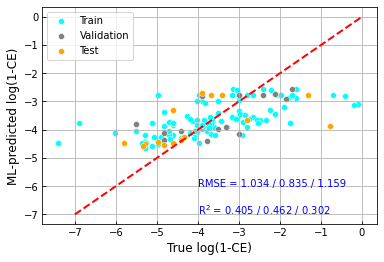

In [67]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

#### Remove extreme values -- not gonna try for now

In [ ]:
## save the two files for future reference and traininf with other algorithms
df_train_ = pd.read_csv('train_CE_feat_pre_red.csv')
df_test_ = pd.read_csv('test_CE_feat_pre_red.csv')
df_train_

In [ ]:
X_train = df_train_.iloc[:,8:-2]
y_train = df_train_.iloc[:,-1]
X_test = df_test_.iloc[:,8:-2]
y_test = df_test_.iloc[:,-1]
X_test

In [57]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)

In [47]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 20, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 20, 300),
        # "criterion": trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'poisson']),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
        "random_state": trial.suggest_int("random_state", 0, 100)
    }
    
    rf = RandomForestRegressor(**param)
    # rf.fit(X_train, y_train)
    # y_pred_train = rf.predict(X_train)
    # score = np.sqrt(mean_squared_error(y_train, y_pred_train))
    score = cross_val_score(rf, X_train_std, y_train, cv=kf, scoring="neg_mean_squared_error")
    return rmse_score(score.mean())

In [ ]:
fname = 'best-paramters_rf_' + str(50) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_rf_optuna_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [49]:
p1, p2, p3, p4, p5, p6, p7 = read_param(50)
params = {'min_samples_split': p1, 'min_samples_leaf': p2, 'n_estimators': p3, 
         'max_features': p4, 'max_depth': p5, 'max_leaf_nodes': p6,
         'random_state': p7}
print(p1, p2, p3, p4, p5, p6, p7)

20 1 183 sqrt 48 45 44


In [ ]:
R2_train_array = []; R2_test_array = []
rmse_train_array = []; rmse_test_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    rf = RandomForestRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_std):
        X_train_cv, y_train_cv = X_train_std.iloc[train_ind,:], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_std.iloc[test_ind,:], y_train.iloc[test_ind]
        rf.fit(X_train_cv, y_train_cv)
    y_pred_train = rf.predict(X_train_std)
    y_pred_test = rf.predict(X_test_std)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    R2_train = r2_score(y_train, y_pred_train)
    R2_test = r2_score(y_test, y_pred_test)
    rmse_train_array.append(rmse_train)
    rmse_test_array.append(rmse_test)
    R2_train_array.append(R2_train)
    R2_test_array.append(R2_test)
    print(rmse_train, rmse_test)
    model.append(rf)

In [ ]:
min_rmse = min(rmse_test_array)
ind = rmse_test_array.index(min_rmse)
print(ind)
model_4 = model[ind]
y_pred_train = model_4.predict(X_train_std)
y_pred_test = model_4.predict(X_test_std)
print("Best RMSE for train/test: {}/{}".format(rmse_train_array[ind], rmse_test_array[ind]))
print("Best R2 for train/test: {}/{}".format(R2_train_array[ind], R2_test_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

In [ ]:
xl = np.arange(-7,1,1)
yl = np.arange(-7,1,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log(1-CE)',fontsize=12)
plt.ylabel('ML-predicted log(1-CE)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
# sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-4, -6, 'RMSE = {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_test_array[ind]), color='blue')
plt.text(-4, -7, 'R$^2$ = {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_test_array[ind]), color='blue')
plt.show()
# plt.savefig('remove_lowest_70.jpg', dpi=300)

**Predict on OOD**

In [ ]:
y_pred_ood = model_4.predict(X_ood_std)
y_pred_ood

In [ ]:
plot_parity(y_ood, y_pred_ood)

**Predict on reduced OOD data -- definitely run this**

In [68]:
ood_ind = [2,5,6]
df_ood_ = df_ood.copy()
df_ood_.drop(index=ood_ind, inplace=True)
df_ood_.reset_index(inplace=True, drop=True)
df_ood_

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,...,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density,coulombic_efficiency,log(1-CE)
0,FC(F)(F)COCCOCCOCC(F)(F)F,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,568.741330,57.725716,52.314514,-26.843203,...,0,0,0,0,0,0,2,0.5,0.991411,-4.757323
1,FCCOCCOCCOCCF,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,314.174320,136.484940,26.495731,-17.763567,...,0,0,0,0,0,0,2,0.5,0.874748,-2.077424
2,CCOC(OCC)OCC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-495.069200,19.423439,-9.941760,11.514219,...,0,0,0,0,0,0,2,0.5,0.984961,-4.197091
3,COCCOCC(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,155.699400,-110.856630,5.280405,77.235680,...,0,0,0,0,0,0,2,0.5,0.974294,-3.661018
4,COCCOC(C)(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,307.999420,-51.896534,12.827153,70.621666,...,0,0,0,0,0,0,2,0.5,0.982281,-4.033095
5,CCCCOCCOC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,0.473899,113.481330,17.095774,19.033155,...,0,0,0,0,0,0,2,0.5,0.983000,-4.074542
6,COCCOC(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,254.200800,-89.463520,6.972825,83.248620,...,0,0,0,0,0,0,2,0.5,0.985000,-4.199705
7,CCOCCOC(C)C,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,73.645360,-90.855064,2.386254,67.773544,...,0,0,0,0,0,0,2,0.5,0.989000,-4.509860
8,CCC[Si](OC)(OC)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-110.040060,2.599045,-3.462972,-0.363976,...,0,0,0,0,0,0,2,0.5,0.980000,-3.912023
9,CCCCCC[Si](OC)(OC)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,-480.540280,-23.481226,-15.529446,6.733684,...,0,0,0,0,0,0,2,0.5,0.857000,-1.944911


In [69]:
X_ood = df_ood_.iloc[:,6:-2]
y_ood = df_ood_.iloc[:,-1]

In [70]:
X_ood_std = std_scale.transform(X_ood)
X_ood_std = pd.DataFrame(X_ood_std, columns=X_train.columns)
X_ood_std

,pre_feat_solv_1,pre_feat_solv_2,pre_feat_solv_3,pre_feat_solv_4,pre_feat_solv_5,pre_feat_solv_6,pre_feat_solv_7,pre_feat_solv_8,pre_feat_solv_9,pre_feat_solv_10,...,pre_feat_add_5,pre_feat_add_6,pre_feat_add_7,pre_feat_add_8,pre_feat_add_9,pre_feat_add_10,num_heavy_atoms_add,mw_add,protocol,current_density
0,1.580545,0.817018,1.849657,-1.278861,0.708971,0.489143,0.384968,2.138487,-0.801303,-1.501468,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
1,0.870511,2.015609,0.977733,-0.842785,0.800119,0.359890,0.655416,-1.374343,0.376169,-1.592507,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
2,-1.386619,0.234118,-0.252795,0.563367,0.487825,-0.621362,2.150874,0.554142,-1.654915,1.580524,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
3,0.428495,-1.748540,0.261272,3.719834,0.512033,0.482722,2.069830,0.776490,1.286732,-1.913394,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
4,0.853288,-0.851260,0.516132,3.402176,0.920333,1.019439,2.126261,1.106635,1.229615,-0.897702,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
5,-0.004458,1.665531,0.660287,0.924486,-0.491621,-0.680860,0.535704,-1.093531,0.096793,-0.369301,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
6,0.703233,-1.422970,0.318426,4.008623,0.512753,0.873668,1.843635,1.179820,0.888352,-1.141851,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
7,0.199631,-1.444147,0.163533,3.265387,1.147336,0.333236,2.440292,0.758463,1.781834,-1.465974,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
8,-0.312702,-0.021923,-0.034000,-0.007118,0.216992,-0.835448,3.456388,-0.119646,-1.219900,2.531377,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556
9,-1.346095,-0.418824,-0.441496,0.333768,0.243239,-1.073470,3.102424,-0.654008,-0.817257,1.710344,...,0.046688,-0.071465,-0.030209,-0.015433,-0.05628,-0.477767,-0.423099,-0.416804,0.650585,-0.406556


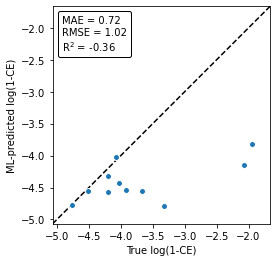

In [71]:
y_ = model_1.predict(X_ood_std)
plot_parity(y_ood, y_)

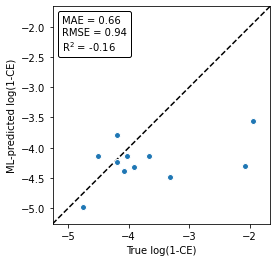

In [72]:
y_2 = model_2.predict(X_ood_std)
plot_parity(y_ood, y_2)

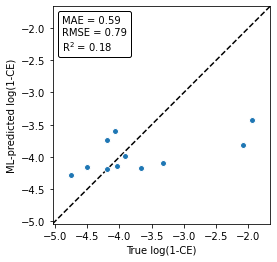

In [73]:
y_3 = model_3.predict(X_ood_std)
plot_parity(y_ood, y_3)

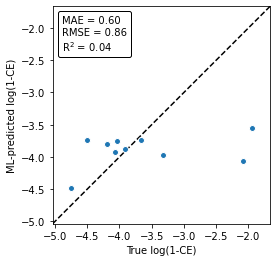

In [74]:
y_4 = model_4.predict(X_ood_std)
plot_parity(y_ood, y_4)

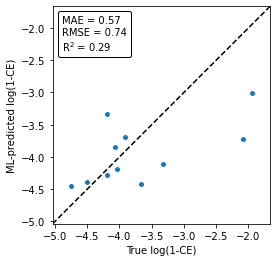

In [75]:
y_5 = model_5.predict(X_ood_std)
plot_parity(y_ood, y_5)

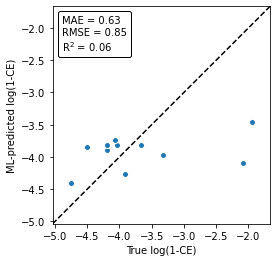

In [76]:
y_6 = model_6.predict(X_ood_std)
plot_parity(y_ood, y_6)

In [55]:
pickle.dump(model_1, open('rf_model2_1_scaled.pkl', 'wb'))
pickle.dump(model_2, open('rf_model2_2_scaled.pkl', 'wb'))
pickle.dump(model_3, open('rf_model2_3_scaled.pkl', 'wb'))
pickle.dump(model_4, open('rf_model2_4_scaled.pkl', 'wb'))
pickle.dump(model_5, open('rf_model2_5_scaled.pkl', 'wb'))
pickle.dump(model_6, open('rf_model2_6_scaled.pkl', 'wb'))